# **BasketBall Playoffs**

### CSV information loaded into Dataframes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder


In [ ]:
awards_players_df = pd.read_csv("data/awards_players.csv")
coaches_df = pd.read_csv("data/coaches.csv")
players_teams_df = pd.read_csv("data/players_teams.csv")
players_df = pd.read_csv("data/players.csv")
series_post_df = pd.read_csv("data/series_post.csv")
teams_post_df = pd.read_csv("data/teams_post.csv")
teams_df = pd.read_csv("data/teams.csv")
players_df.isna().all()

bioID           False
pos             False
firstseason     False
lastseason      False
height          False
weight          False
college         False
collegeOther    False
birthDate       False
deathDate       False
dtype: bool

### Dropping some columns and rows
Some invalid player entries were found with null values in every column.

We also dropped all columns relative to *lgID* as all rows had the same value in every dataframe


In [ ]:
#death date isnt relevant and its value is always 0000-00-00
players_df = players_df.drop(["deathDate","firstseason","lastseason"], axis="columns")
#lgID(Winner/Loser) isnt relevant as its value is always the same
awards_players_df = awards_players_df.drop(["lgID"], axis="columns")
coaches_df = coaches_df.drop(["lgID"], axis="columns")
players_teams_df = players_teams_df.drop(["lgID"], axis="columns")
series_post_df = series_post_df.drop(["lgIDWinner","lgIDLoser"], axis="columns")
teams_post_df = teams_post_df.drop(["lgID"], axis="columns")
teams_df = teams_df.drop(["lgID","seeded","arena","franchID"], axis="columns")
#remove players whose birthDate is 0000-00-00
players_df = players_df[players_df['birthDate'] != '0000-00-00']
players_df = players_df.rename(columns={"bioID": "playerID"})
players_df


,playerID,pos,height,weight,college,collegeOther,birthDate
0,abrahta01w,C,74.0,190,George Washington,NaN,1975-09-27
1,abrossv01w,F,74.0,169,Connecticut,NaN,1980-07-09
2,adairje01w,C,76.0,197,George Washington,NaN,1986-12-19
3,adamsda01w,F-C,73.0,239,Texas A&M,Jefferson College (JC),1989-02-19
4,adamsjo01w,C,75.0,180,New Mexico,NaN,1981-05-24
...,...,...,...,...,...,...,...
887,zarafr01w,G,70.0,146,NaN,NaN,1976-12-08
888,zellosh01w,G,70.0,155,Pittsburgh,NaN,1986-08-28
889,zhengha01w,C,80.0,254,NaN,NaN,1967-03-07
891,zirkozu01w,G,69.0,145,NaN,NaN,1980-06-06


In [4]:
merged_df = pd.merge(players_teams_df, players_df, how="left", on=["playerID"])
merged_df = pd.merge(merged_df, awards_players_df, how="left", on=["playerID","year"])
merged_df["award"] = merged_df["award"].fillna("None")
merged_df["college"] = merged_df["college"].fillna("None")
merged_df["collegeOther"] = merged_df["collegeOther"].fillna("None")
teams_merged_df = pd.merge(teams_df, coaches_df, how="left", on=["year","tmID"])
merged_df = pd.merge(merged_df, teams_merged_df, how="left", on=["year","tmID"])                    



In [ ]:

def calculate_age(merged_df):

    if not pd.api.types.is_datetime64_dtype(merged_df['birthDate']):
        merged_df['birthDate'] = pd.to_datetime(merged_df['birthDate'])
    
    merged_df['age'] = 2014 + merged_df['year'] - merged_df['birthDate'].dt.year
    

    merged_df.drop(columns=['birthDate'],inplace=True)

    return merged_df
    
calculate_age(merged_df)
merged_df
    

,playerID,year,stint_x,tmID,GP_x,GS,minutes,points,oRebounds,dRebounds,...,confL,min,attend,coachID,stint_y,won_y,lost_y,post_wins,post_losses,age
0,abrossv01w,2,0,MIN,26,23,846,343,43,131,...,12,6475,120607,aglerbr99w,0,12,20,0,0,36
1,abrossv01w,3,0,MIN,27,27,805,314,45,101,...,15,6475,139874,aglerbr99w,1,6,13,0,0,37
2,abrossv01w,3,0,MIN,27,27,805,314,45,101,...,15,6475,139874,vandehe99w,2,4,9,0,0,37
3,abrossv01w,4,0,MIN,30,25,792,318,44,97,...,10,6850,120253,mcconsu01w,0,18,16,1,2,38
4,abrossv01w,5,0,MIN,22,11,462,146,17,57,...,10,6850,125097,mcconsu01w,0,18,16,0,2,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,zarafr01w,6,0,SEA,34,4,413,90,11,28,...,9,6825,151150,donovan99w,0,20,14,1,2,44
2156,zellosh01w,10,0,DET,34,4,802,406,25,81,...,11,6975,136069,laimbbi01w,1,1,2,0,0,38
2157,zellosh01w,10,0,DET,34,4,802,406,25,81,...,11,6975,136069,mahorri01w,2,17,14,3,2,38
2158,zirkozu01w,4,0,WAS,6,0,30,11,0,2,...,17,6875,238710,stanlma99w,0,9,25,0,0,38


In [6]:
encoder = LabelEncoder()
merged_df["playoff"] = encoder.fit_transform(merged_df["playoff"])

# print what was mapped to what
for idx, label in enumerate(encoder.classes_):
    print(f"{label}: {idx}")

N: 0
Y: 1


In [7]:
merged_df["college"] = encoder.fit_transform(merged_df["college"])

college_normalization_rules = {
    "NE Oklahoma A&M (JC)":126,
    "Arkansas-Fort Smith (fr-so)":127,
    "Grayson County (JC)":128
}

# print what was mapped to what
for idx, label in enumerate(encoder.classes_):
    college_normalization_rules[label] = idx

    print(f"{label}: {college_normalization_rules[label]}")

Academy of Sport Moscow: 0
Alabama: 1
Alabama-Birmingham: 2
Arizona: 3
Arizona State: 4
Arkansas: 5
Arkansas State: 6
Auburn: 7
Australian Institute of Sport: 8
Baylor: 9
Boise State: 10
Boston College: 11
Brigham Young: 12
California: 13
Central Florida: 14
Cincinnati: 15
Clemson: 16
Colorado: 17
Colorado State: 18
Connecticut: 19
DePaul: 20
Delaware: 21
Denver: 22
Duke: 23
Duquesne: 24
Flordia: 25
Florida: 26
Florida Atlantic: 27
Florida International: 28
Florida State: 29
Furman: 30
George Mason: 31
George Washington: 32
Georgetown: 33
Georgia: 34
Georgia Tech: 35
Harvard: 36
Hawai'i: 37
Houston: 38
Howard: 39
Illinois: 40
Illinois State: 41
Indiana: 42
Iona: 43
Iowa: 44
Iowa State: 45
James Madison: 46
Kansas: 47
Kansas State: 48
Kentucky: 49
Liberty: 50
Long Beach State: 51
Louisiana State: 52
Louisiana Tech: 53
Louisville: 54
Maine: 55
Maryland: 56
Memphis: 57
Miami (FL): 58
Michigan: 59
Michigan State: 60
Middle Tennessee State: 61
Minnesota: 62
Mississippi: 63
Mississippi State

In [8]:
def normalize_collegeOther(name):
    return college_normalization_rules[name]

merged_df["collegeO"] = merged_df["collegeOther"].apply(normalize_collegeOther)
merged_df = merged_df.drop(["collegeOther"], axis="columns")

In [9]:
def normalize_awards(award):
    normalization_rules = {
        "None": 0,
        "All-Star Game Most Valuable Player": 1,
        "Coach of the Year": 2,
        "Defensive Player of the Year": 3,
        "Kim Perrot Sportsmanship": 4,
        "Kim Perrot Sportsmanship Award": 4,
        "Most Improved Player":5,
        "Most Valuable Player":6,
        "Rookie of the Year":7,
        "Sixth Woman of the Year":8,
        "WNBA Finals Most Valuable Player":9,
        "WNBA All-Decade Team":10,
        "WNBA All Decade Team Honorable Mention":11
    }
    return normalization_rules[award]

merged_df["normalized_award"] = merged_df["award"].apply(normalize_awards)
merged_df = merged_df.drop(["award"], axis="columns")


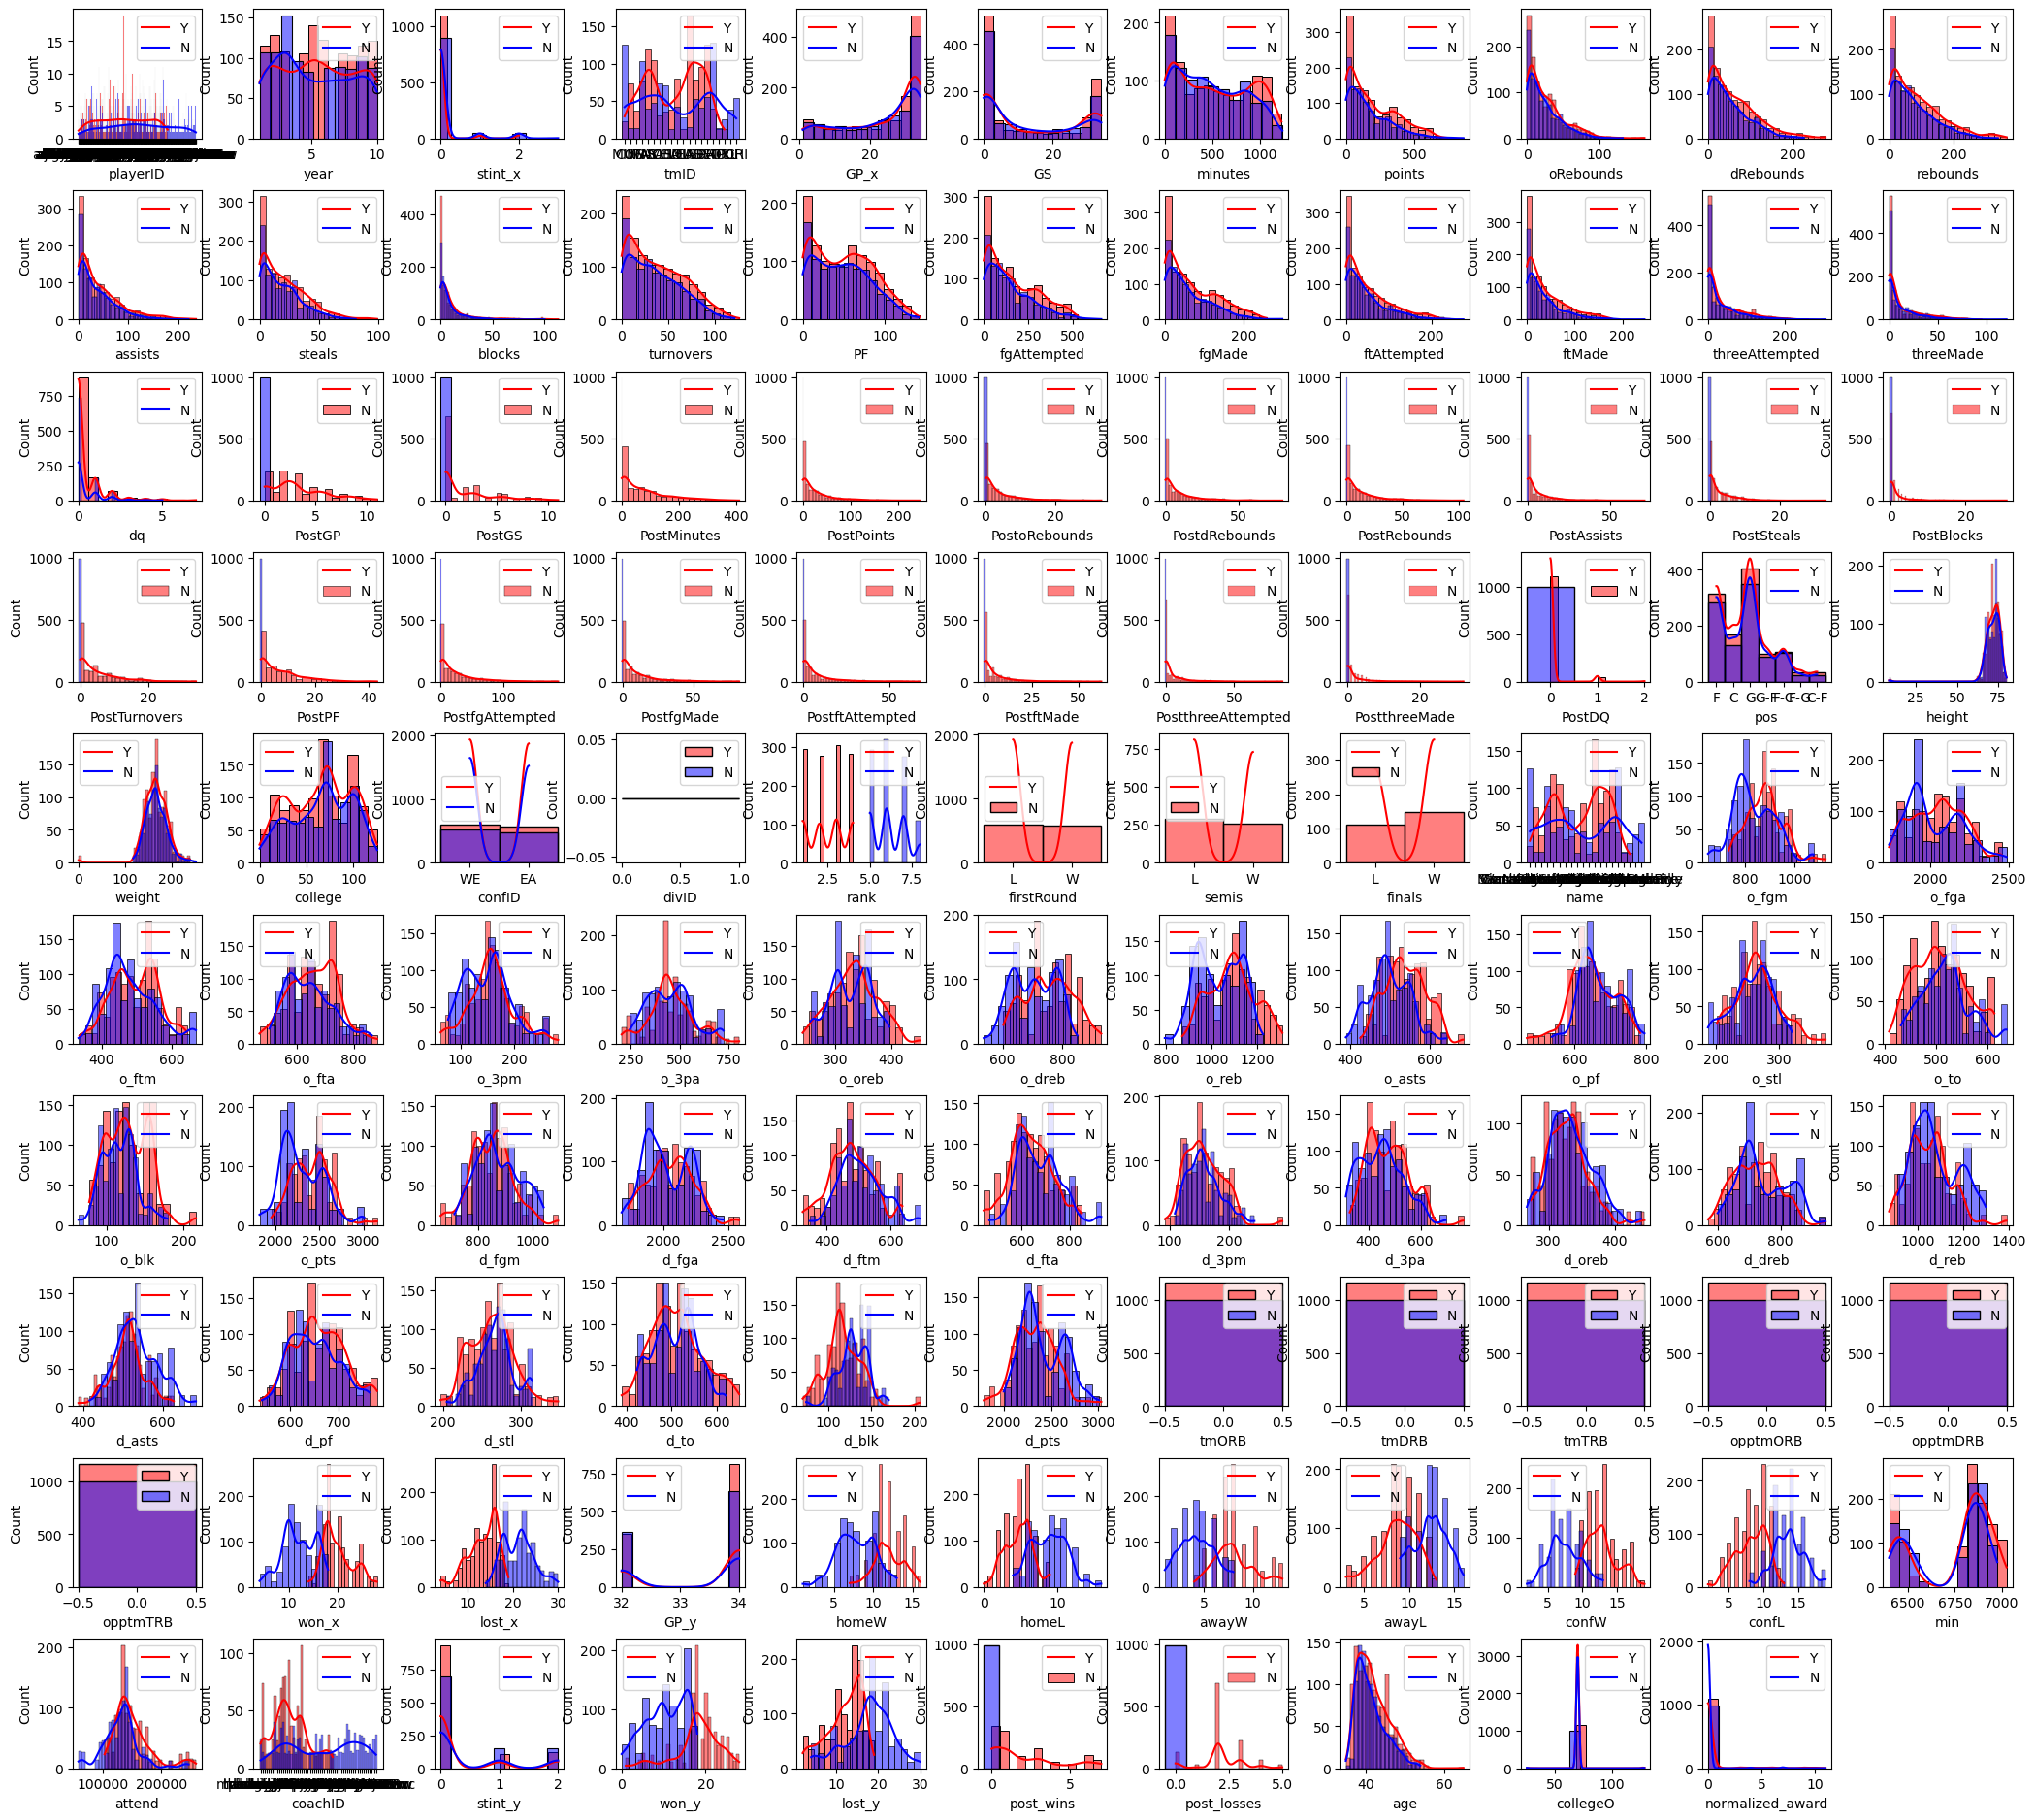

In [10]:
plt.figure(figsize=(25,25))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

merged_df1 = merged_df[merged_df['playoff']==1].drop(['playoff'],axis=1)
merged_df2 = merged_df[merged_df['playoff']==0].drop(['playoff'],axis=1)

cols = list(merged_df1.columns)

for i, col in enumerate(cols):
    plt.subplot(11,11,i+1)
    sb.histplot(data=merged_df1[col], color='red', label = 'Y', kde=True)
    sb.histplot(data=merged_df2[col], color='blue', label = 'N', kde=True)
    _,axes = plt.gca().get_legend_handles_labels()
    plt.legend(axes,prop={'size': 10})

plt.show()

In [11]:

merged_df.head()


,playerID,year,stint_x,tmID,GP_x,GS,minutes,points,oRebounds,dRebounds,...,attend,coachID,stint_y,won_y,lost_y,post_wins,post_losses,age,collegeO,normalized_award
0,abrossv01w,2,0,MIN,26,23,846,343,43,131,...,120607,aglerbr99w,0,12,20,0,0,36,70,0
1,abrossv01w,3,0,MIN,27,27,805,314,45,101,...,139874,aglerbr99w,1,6,13,0,0,37,70,0
2,abrossv01w,3,0,MIN,27,27,805,314,45,101,...,139874,vandehe99w,2,4,9,0,0,37,70,0
3,abrossv01w,4,0,MIN,30,25,792,318,44,97,...,120253,mcconsu01w,0,18,16,1,2,38,70,0
4,abrossv01w,5,0,MIN,22,11,462,146,17,57,...,125097,mcconsu01w,0,18,16,0,2,39,70,0
